In [1]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import numpy as np
import pandas as pd
from itertools import *
import sklearn
import math
import random
import sys
import multiprocessing
nproc = max(1, multiprocessing.cpu_count() - 1)

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

print(data_loader.load_chromosome.__doc__)
train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')
    
sess = tf.InteractiveSession()

Idempotent data loading. For a given chromosome n (a string).
    
    Returns (train_df, test_df, train_ix, test_ix, train_tissues, tfs)
    
    The first two are the train and test dataframes, and test_ix are the
    values in test_df['assayed'] that are missing and need to be imputed (with the
    correct answer being in test_df['filled'] in the corresponding locations.
    train_ix are the assayed (known) methylation values from limited microarray
    sampling (e.g., test_df['assayed'].iloc[train_ix] can be used for prediction of
    test_df['filled'].iloc[test_ix], and the former should be about equal to
    test_df['filled'].iloc[train_ix] (two different ways of sampling methylation).
    
    Imports genetic context and adds those columns to the parameter df, returning
    a merged one. tfs is the list of names of new transcription
    factors.
    
    train_tissues is a list of the names of columns with chromosome methylation values.
    
    Note that loading from scratch ma

In [2]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

# Do mean imputation on our training data.
def mean_impute(data):
    mask = np.isnan(data)
    data[mask] = float(data.mean()) # just = m messes with serialization
    return data
train_df_imp = train_df
train_df_int = train_df
for i in train_tissues:
    train_df_imp[i] = mean_impute(train_df[i].copy())
    train_df_int[i] = local_impute(train_df[i].copy())
print('nans in mean-imputed', np.isnan(train_df_imp[train_tissues]).sum().sum())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in mean-imputed 0
nans in interpolated 0


In [40]:
# Copied pretty much directly from sklearn

# Returns a TensorFlow scalar with the size of the i-th dimension for
# the parameter tensor x.
def tf_get_shape(x, i):
    return tf.squeeze(tf.slice(tf.shape(x), [i], [1])) 

def tf_nrows(x):
    return tf_get_shape(x, 0)

def tf_ncols(x):
    return tf_get_shape(x, 1)

# Simultaneous K-cluster likelihood computation.
# X is NxD, mus is KxD, sigmas is KxD
# Output is KxN likelihoods for each sample in each cluster.
def tf_log_normals(X, mus, sigmas):
    # p(X) = sqrt(a * b * c)
    # a = (2 pi)^(-p)
    # b = det(sigma)^(-1)
    # c = exp(-(x - mu)^T sigma^(-1) (x - mu)) [expanded for numerical stability]
    #
    # Below we make simplifications since sigma is diag
    
    D = tf_ncols(mus)
    XT = tf.transpose(X) # pxN
    invsig = tf.inv(sigmas)
    
    loga = -tf.cast(D, 'float64') * tf.log(tf.constant(2 * np.pi, dtype='float64')) # scalar
    logb = tf.reduce_sum(tf.log(invsig), 1, keep_dims=True) # Kx1
    logc =  \
        - tf.reduce_sum(invsig * tf.square(mus), 1, keep_dims=True) \
        + 2 * tf.matmul(invsig * mus, XT) \
        - tf.matmul(invsig, tf.square(XT)) # KxN
    return 0.5 * (loga + logb + logc)

# Stably log-sum-exps likelihood along rows.
# Reduces KxN tensor L to 1xN tensor
def tf_log_sum_exp(L):
    maxs = tf.reduce_max(L, 0, keep_dims=True) # 1xN
    return tf.log(tf.reduce_sum(tf.exp(L - maxs), 0, keep_dims=True)) + maxs

# X is NxD, mus is KxD, sigmas KxD, alphas is K
# output is KxN log likelihoods.
def tf_log_likelihood(X, mus, sigmas, alphas):
    alphas = tf.expand_dims(alphas, 1) # Kx1
    return tf_log_normals(X, mus, sigmas) + tf.log(alphas) # KxN

# X is NxD, mus is KxD, sigmas KxD, alphas is K
# output is 1xN log probability for each sample, KxN responsibilities
def estep(X, mus, sigmas, alphas):
    log_likelihoods = tf_log_likelihood(X, mus, sigmas, alphas)
    sample_log_prob = tf_log_sum_exp(log_likelihoods) # 1xN
    return sample_log_prob, tf.exp(log_likelihoods - sample_log_prob)

EPS = np.finfo(float).eps
MIN_COVAR = EPS
# X is NxD, resp is KxN (and normalized along axis 0)
# Returns maximize step means, covariance, and cluster priors,
# which have dimension KxD, KxD, and K, respectively
def mstep(X, resp):
    weights = tf.reduce_sum(resp, 1) # K
    invweights = tf.expand_dims(tf.inv(weights + 10 * EPS), 1) # Kx1
    alphas = EPS + weights / (tf.reduce_sum(weights) + 10 * EPS) # K
    weighted_cluster_sum = tf.matmul(resp, X) # KxD 
    mus = weighted_cluster_sum * invweights
    avg_X2 = tf.matmul(resp, tf.square(X)) * invweights
    avg_mu2 = tf.square(mus)
    avg_X_mu = mus * weighted_cluster_sum * invweights
    sigmas = avg_X2 - 2 * avg_X_mu + avg_mu2 + MIN_COVAR
    # (x - mu) (x-mu)^T for banded. 
    return mus, sigmas, alphas

In [41]:
# Make sure N, D are small so the numerically unstable verification code
# doesn't underflow.
N = 5
D = 10

X = np.random.normal(size=(N, D))
mu = X.mean(axis=0)
sigma = X.std(axis=0)
mus = np.array([mu, mu, mu * 2])
sigmas = np.array([sigma, sigma * 2, sigma])
K = len(sigmas)
alphas = np.random.dirichlet(np.ones(K), 1)[0]

mean_ll, resp = sess.run(estep(*(tf.constant(x) for x in (X, mus, sigmas, alphas))))
def normal_likelihoods(X, mu, sigma):
    exponent = -np.dot((X - mu[np.newaxis, :]) ** 2, 1 / sigma) / 2
    return (2 * np.pi) ** (-D / 2) * np.prod(sigma) ** (-1 / 2) * np.exp(exponent)
actual = np.array([normal_likelihoods(X, mu, sigma) for mu, sigma in zip(mus, sigmas)])
actual = sklearn.preprocessing.normalize(actual * alphas[:, np.newaxis], norm='l1', axis=0)
resp = sklearn.preprocessing.normalize(resp, norm='l1', axis=0)
print('actual likelihoods', actual)
print('log likelihoods   ', resp)
rmses = np.sqrt(sklearn.metrics.mean_squared_error(actual.T, resp.T, multioutput='raw_values'))
for i, rmse in enumerate(rmses):
    print('K={} rmse={}'.format(i, rmse))

actual likelihoods [[ 0.51253502  0.69516936  0.39933126  0.56498848  0.48456228]
 [ 0.47463365  0.10770238  0.36001882  0.38406837  0.31807052]
 [ 0.01283134  0.19712826  0.24064992  0.05094316  0.1973672 ]]
log likelihoods    [[ 0.51253502  0.69516936  0.39933126  0.56498848  0.48456228]
 [ 0.47463365  0.10770238  0.36001882  0.38406837  0.31807052]
 [ 0.01283134  0.19712826  0.24064992  0.05094316  0.1973672 ]]
K=0 rmse=5.512120354514498e-16
K=1 rmse=5.277940006822452e-16
K=2 rmse=1.0186534949870763e-16


In [44]:
# Similar pattern to
# https://gist.github.com/narphorium/d06b7ed234287e319f18

#todo try initializing covar to emprical cv computed from kmeans labels

# Runs up to max_steps EM iterations, stopping earlier if log likelihood improves
# less than tol.
# X should be an NxD data matrix, initial_mus should be KxD
# max_steps should be an int, tol should be a float.
def fit_em(X, initial_mus, max_steps, tol):
    N, D = X.shape
    K, Dmu = initial_mus.shape
    assert D == Dmu
        
    mus0 = initial_mus
    sigmas0 = np.tile(np.var(X, axis=0), (K, 1))
    alphas0 = np.ones(K)
    X = tf.constant(X)
    
    mus, sigmas, alphas = (tf.Variable(x, dtype='float64') for x in [mus0, sigmas0, alphas0])
        
    all_ll, resp = estep(X, mus, sigmas, alphas)
    cmus, csigmas, calphas = mstep(X, resp)
    update_mus_step = tf.assign(mus, cmus)
    update_sigmas_step = tf.assign(sigmas, csigmas)
    update_alphas_step = tf.assign(alphas, calphas)     
    
    init_op = tf.initialize_all_variables()
    ll = prev_ll = -np.inf
                         
    with tf.Session() as sess:
        sess.run(init_op)
        for i in range(max_steps):
            ll = sess.run(tf.reduce_mean(all_ll))
            sess.run((update_mus_step, update_sigmas_step, update_alphas_step))
            print('EM iteration', i, 'log likelihood', ll)
            if abs(ll - prev_ll) < tol:
                print('Converged in', i, 'iterations')
                break
            prev_ll = ll
        m, s, a = sess.run((mus, sigmas, alphas))
        
    return ll, m, s, a

In [35]:
# Given a full normal distribution with
# mu, sigma as the mean and diagonal of the covariance matrix, respectively, with
# dimension D, and an observation x of dimension O < D for values 1:O,
# returns muP, sigmaP, of dimension D-O, for the remaining dimensions.
def marginal_posterior(mu, sigma, x):
    # https://gbhqed.wordpress.com/2010/02/21/conditional-and-marginal-distributions-of-a-multivariate-gaussian/
    # diagonal case is easy:
    O = len(x)
    D = len(mu)
    return mu[O:D], sigma[O:D]

# todo how to combine from mixture model?

EM iteration 0 log likelihood -6.36975431377
EM iteration 1 log likelihood -6.61251567658
EM iteration 2 log likelihood -6.31209857863
EM iteration 3 log likelihood -6.1336037004
EM iteration 4 log likelihood -5.89337363174
EM iteration 5 log likelihood -5.59161802436
EM iteration 6 log likelihood -5.25342589664
EM iteration 7 log likelihood -4.93217219687
EM iteration 8 log likelihood -4.839754903
EM iteration 9 log likelihood -4.83810526122
EM iteration 10 log likelihood -4.8380421483
EM iteration 11 log likelihood -4.83802916037
EM iteration 12 log likelihood -4.83802644918
EM iteration 13 log likelihood -4.83802587952
EM iteration 14 log likelihood -4.83802575947
EM iteration 15 log likelihood -4.83802573413
EM iteration 16 log likelihood -4.83802572878
EM iteration 17 log likelihood -4.83802572765
EM iteration 18 log likelihood -4.83802572741
EM iteration 19 log likelihood -4.83802572736
EM iteration 20 log likelihood -4.83802572735
EM iteration 21 log likelihood -4.83802572735
EM

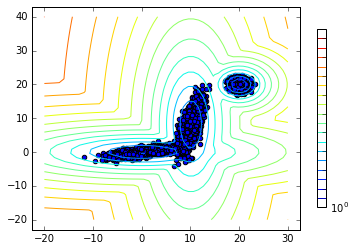

In [48]:
n_samples = 1000
np.random.seed(0)

def MVN(shear, shift):
    rs = np.random.randn(n_samples, 2)
    return np.dot(rs, shear.T) + shift
G1 = MVN(np.identity(2), np.array([20, 20]))
G2 = MVN(np.array([[0., 3.5], [-0.7, .7]]), np.zeros(2))
G3 = MVN(np.array([[-1, 0.8], [0, 4]]), np.array([10, 8]))

# concatenate the two datasets into the final training set
X = np.vstack([G1, G2, G3])
rx = np.random.choice(range(len(X)), 3, replace=False)

# http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html
_, m, s, a = fit_em(X, X[rx], 100, EPS)
x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
xx, yy = np.meshgrid(x, y)
pts = np.array([xx.ravel(), yy.ravel()]).T
ll = -estep(pts, m, s, a)[0].eval()
print('means\n{}\ncov\n{}\ncluster priors\n{}'.format(m, s, a))
CS = plt.contour(xx, yy, ll.reshape(xx.shape), norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 20))
plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [30]:
N = 10
p = 20 # D is better?
K = 3
k = 0 # maximum band offset (0 is just diagonal)
tissues_to_cluster = train_tissues
X_np = train_df_imp[train_tissues].values.transpose()

np.random.seed(0)
rc = np.random.choice(range(len(train_df)), D, replace=False)
rmu = np.random.choice(range(N), K, replace=False)

X_trunc = X_np[:N, rc]
mu_init = X_trunc[rmu]

In [34]:
## Implement custom GMM
#todo check float32/float64 conversion for speedup
#todo scale (standardize) data before running
#todo kmeans warmup (just in numpy?)
#todo mincovar
lp, m, s, a = fit_em(X_trunc, mu_init, 100, EPS)
print('mean log likelihood\n{}\nmeans\n{}\ncov\n{}\ncluster priors\n{}'
      .format(lp, m, s, a))

EM iteration 0 log likelihood 10.5128845776
EM iteration 1 log likelihood 14.3378001876
EM iteration 2 log likelihood 15.2654497828
EM iteration 3 log likelihood 16.0180952721
EM iteration 4 log likelihood 16.1997659211
EM iteration 5 log likelihood 16.1997659266
EM iteration 6 log likelihood 16.1997659266
EM iteration 7 log likelihood 16.1997659267
EM iteration 8 log likelihood 16.1997659267
EM iteration 9 log likelihood 16.1997659267
EM iteration 10 log likelihood 16.1997659267
EM iteration 11 log likelihood 16.1997659267
EM iteration 12 log likelihood 16.1997659267
EM iteration 13 log likelihood 16.1997659267
EM iteration 14 log likelihood 16.1997659267
EM iteration 15 log likelihood 16.1997659267
EM iteration 16 log likelihood 16.1997659267
EM iteration 17 log likelihood 16.1997659267
EM iteration 18 log likelihood 16.1997659267
EM iteration 19 log likelihood 16.1997659267
EM iteration 20 log likelihood 16.1997659267
EM iteration 21 log likelihood 16.1997659267
EM iteration 22 log 